# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Msc. BDS - M7 Second Semester Project** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Training Pipeline</span>

## <span style='color:#2656a3'> 🗒️ This notebook is divided into the following sections:
1. Feature selection.
2. Creating a Feature View.
3. Training datasets creation - splitting into train and test sets.
4. Training the model.
5. Register the model to Hopsworks Model Registry.

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages
We start with importing some of the necessary libraries needed for this notebook and warnings to avoid unnecessary distractions and keep output clean.

In [1]:
# Importing the packages and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store
We connect to Hopsworks Feature Store so we can retrieve the Feature Groups and select features for training data.

In [2]:
# Importing the hopsworks module for interacting with the Hopsworks platform
import hopsworks

# Logging into the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/550040
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# Retrieve the feature groups
electricity_fg = fs.get_feature_group(
    name='electricity_prices',
    version=1,
)

weather_fg = fs.get_feature_group(
    name='weather_measurements',
    version=1,
)

danish_calendar_fg = fs.get_feature_group(
    name='dk_calendar',
    version=1,
)

## <span style="color:#2656a3;"> 🖍 Feature View Creation and Retrieving </span>

We first select the features that we want to include for model training.

Since we specified `primary_key`as `date` and `timestamp` in `1_feature_backfill` we can now join them together for the `electricity_fg`, `weather_fg` and `danish_holiday_fg`.

`join_type` specifies the type of join to perform. An inner join refers to only retaining the rows based on the keys present in all joined DataFrames.

In [4]:
# Select features for training data and join them together and except duplicate columns
selected_features_training = electricity_fg.select_all()\
    .join(weather_fg.select_except(["timestamp", "datetime", "hour"]), join_type="inner")\
    .join(danish_calendar_fg.select_all(), join_type="inner")

In [5]:
# Display the first 5 rows of the selected features
selected_features_training.show(5)

Finished: Reading data from Hopsworks, using ArrowFlight (4.00s) 


,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
0,1682280000000,2023-04-23 20:00:00+00:00,2023-04-23,20,1.02178,10.4,74.0,0.0,0.0,0.0,3.0,100.0,7.6,10.1,6,23,4,2023,0
1,1678816800000,2023-03-14 18:00:00+00:00,2023-03-14,18,0.77461,0.5,88.0,0.0,0.0,0.0,0.0,0.0,11.6,22.7,1,14,3,2023,1
2,1697259600000,2023-10-14 05:00:00+00:00,2023-10-14,5,-0.01551,9.8,71.0,0.0,0.0,0.0,1.0,23.0,29.5,54.7,5,14,10,2023,0
3,1657170000000,2022-07-07 05:00:00+00:00,2022-07-07,5,1.15795,15.0,90.0,0.1,0.1,0.0,51.0,59.0,16.6,31.3,3,7,7,2022,1
4,1647597600000,2022-03-18 10:00:00+00:00,2022-03-18,10,1.48754,8.4,60.0,0.0,0.0,0.0,0.0,0.0,21.9,45.4,4,18,3,2022,1


A `Feature View` stands between the **Feature Groups** and **Training Dataset**. Сombining **Feature Groups** we can create a **Feature View** which stores a metadata of our data. Having the **Feature View** we can create a **Training Dataset**.

In order to create Feature View we can use `fs.get_or_create_feature_view()` method.

We can specify parameters:

- `name` - Name of the feature view to create.
- `version` - Version of the feature view to create.
- `query` - Query object with the data.

In [6]:
# Getting or creating a feature view named 'dk1_electricity_training_feature_view'
version = 1
feature_view_training = fs.get_or_create_feature_view(
    name='dk1_electricity_training_feature_view',
    version=version,
    query=selected_features_training,
)

## <span style="color:#2656a3;"> 🏋️ Training Dataset Creation</span>

In Hopsworks, a training dataset is generated from a query defined by the parent FeatureView, which determines the set of features.

**Training Dataset may contain splits such as:** 
* Training set: This subset of the training data is utilized for model training.
* Validation set: Used for evaluating hyperparameters during model training. *(We have not included a validation set for this project)*
* Test set: Reserved as a holdout subset of training data for evaluating a trained model's performance.

Training dataset is created using `fs.training_data()` method.

In [7]:
# Retrieve training data from the feature view 'feature_view_training', assigning the features to 'X'.
df, _ = feature_view_training.training_data(
    description = 'Electricity Prices Training Dataset',
)

Finished: Reading data from Hopsworks, using ArrowFlight (3.73s) 


In [8]:
# Sorting the dataframe by timestamp for better performance for temporal models
df.sort_values(by='timestamp', ascending=True, inplace=True)

# Resetting the index of the dataframe
df = df.reset_index(drop=True)

# Display the first 5 rows of the training data
df.head()

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
0,1640995200000,2022-01-01 00:00:00+00:00,2022-01-01,0,0.37220,6.7,100.0,0.0,0.0,0.0,3.0,100.0,16.2,36.0,5,1,1,2022,0
1,1640998800000,2022-01-01 01:00:00+00:00,2022-01-01,1,0.30735,6.6,100.0,0.0,0.0,0.0,3.0,100.0,16.2,30.2,5,1,1,2022,0
2,1641002400000,2022-01-01 02:00:00+00:00,2022-01-01,2,0.32141,6.7,99.0,0.0,0.0,0.0,3.0,100.0,15.5,30.6,5,1,1,2022,0
3,1641006000000,2022-01-01 03:00:00+00:00,2022-01-01,3,0.33806,6.7,100.0,0.0,0.0,0.0,3.0,100.0,12.7,28.8,5,1,1,2022,0
4,1641009600000,2022-01-01 04:00:00+00:00,2022-01-01,4,0.28013,6.7,99.0,0.0,0.0,0.0,3.0,100.0,10.6,23.8,5,1,1,2022,0


### Lagged data

In [9]:
# # Creating a copy of the dataframe
# df_lagged = df.copy()

# # Creating lag features for time-series data
# def create_lag_features(data, lag_steps=168): # lag_steps is the number of lag features before the current observation
#     for i in range(1, lag_steps + 1):
#         data[f'lag_{i}'] = data['dk1_spotpricedkk_kwh'].shift(i) # Shifting the data by i steps
#     return data

# # Applying lag feature creation to the dataset
# lagged_data = create_lag_features(df_lagged, lag_steps=168) # Creating 48 lag features on dk1_spotpricedkk_kwh

In [10]:
# lagged_data.tail()

### Rolling and Sliding Mean Window

In [11]:
rolled_data = df.copy()

# Adding a column with the mean for the previous 6 hours
rolled_data['prev_1w_mean'] = rolled_data['dk1_spotpricedkk_kwh'].rolling(window=24*7).mean()

# Adding a column with the mean for the previous 12 hours
rolled_data['prev_2w_mean'] = rolled_data['dk1_spotpricedkk_kwh'].rolling(window=24*14).mean()

# Adding a column with the mean for the previous 24 hours
rolled_data['prev_4w_mean'] = rolled_data['dk1_spotpricedkk_kwh'].rolling(window=24*28).mean()

rolled_data.tail()

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,...,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday,prev_1w_mean,prev_2w_mean,prev_4w_mean
20910,1716368400000,2024-05-22 09:00:00+00:00,2024-05-22,9,0.24832,20.1,54.0,0.0,0.0,0.0,...,24.5,46.4,2,22,5,2024,1,0.296633,0.317703,0.409030
20911,1716372000000,2024-05-22 10:00:00+00:00,2024-05-22,10,0.23370,21.3,52.0,0.0,0.0,0.0,...,25.9,49.0,2,22,5,2024,1,0.297697,0.316502,0.408458
20912,1716375600000,2024-05-22 11:00:00+00:00,2024-05-22,11,0.22139,22.4,50.0,0.0,0.0,0.0,...,27.4,52.6,2,22,5,2024,1,0.299018,0.315397,0.407929
20913,1716379200000,2024-05-22 12:00:00+00:00,2024-05-22,12,0.15281,23.4,49.0,0.0,0.0,0.0,...,28.1,54.0,2,22,5,2024,1,0.300017,0.314271,0.407297
20914,1716382800000,2024-05-22 13:00:00+00:00,2024-05-22,13,0.02694,24.2,48.0,0.0,0.0,0.0,...,27.4,54.0,2,22,5,2024,1,0.300236,0.312977,0.406455


In [12]:
rolled_data.head()

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,...,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday,prev_1w_mean,prev_2w_mean,prev_4w_mean
0,1640995200000,2022-01-01 00:00:00+00:00,2022-01-01,0,0.37220,6.7,100.0,0.0,0.0,0.0,...,16.2,36.0,5,1,1,2022,0,NaN,NaN,NaN
1,1640998800000,2022-01-01 01:00:00+00:00,2022-01-01,1,0.30735,6.6,100.0,0.0,0.0,0.0,...,16.2,30.2,5,1,1,2022,0,NaN,NaN,NaN
2,1641002400000,2022-01-01 02:00:00+00:00,2022-01-01,2,0.32141,6.7,99.0,0.0,0.0,0.0,...,15.5,30.6,5,1,1,2022,0,NaN,NaN,NaN
3,1641006000000,2022-01-01 03:00:00+00:00,2022-01-01,3,0.33806,6.7,100.0,0.0,0.0,0.0,...,12.7,28.8,5,1,1,2022,0,NaN,NaN,NaN
4,1641009600000,2022-01-01 04:00:00+00:00,2022-01-01,4,0.28013,6.7,99.0,0.0,0.0,0.0,...,10.6,23.8,5,1,1,2022,0,NaN,NaN,NaN


In [13]:
# # Function to calculate the sliding window mean for specified window sizes
# def calculate_sliding_window_means(data, window_sizes):
#     for window_size in window_sizes:
#         column_name = f'prev_{window_size}h_mean_sliding'
#         sliding_mean = []
#         for i in range(len(data)):
#             if i < window_size:
#                 sliding_mean.append(np.nan)  # Not enough data points to fill the window
#             else:
#                 window_data = data['dk1_spotpricedkk_kwh'].iloc[i-window_size:i]
#                 sliding_mean.append(window_data.mean())
#         data[column_name] = sliding_mean
#     return data

# # Applying the sliding window mean calculation for both 24 hours and 48 hours
# window_sizes = [24, 48]
# window_data = calculate_sliding_window_means(rolled_data, window_sizes)

# window_data.tail()


In [14]:
#window_data.head()

### <span style="color:#2656a3;"> ⛳️ Dataset with train and test splits</span>

Here we define our train and test splits for traning the model.

In [15]:
# Dropping the timestamp, datetime and date columns from the lagged and window data
#lagged_data = lagged_data.drop(['timestamp', 'datetime', 'date'], axis=1)
window_data = rolled_data.drop(['timestamp', 'datetime', 'date'], axis=1)

In [16]:
# Splitting time-series data into training and testing sets

# Splitting the data into training and testing sets for lagged features
# train_size_lagged = int(len(lagged_data) * 0.8)

# X_train_data_lag, X_test_data_lag = lagged_data[:train_size_lagged], lagged_data[train_size_lagged:]

# Splitting the data into training and testing sets for rolling and sliding mean
train_size_win = int(len(window_data) * 0.8)

X_train_data_win, X_test_data_win = window_data[:train_size_win], window_data[train_size_win:]

In [17]:
# Splitting the target variable into training and testing sets for lagged features
# y_train_data_lag = X_train_data_lag.pop('dk1_spotpricedkk_kwh')
# y_test_data_lag = X_test_data_lag.pop('dk1_spotpricedkk_kwh')

# Splitting the target variable into training and testing sets for rolling mean
y_train_data_win = X_train_data_win.pop('dk1_spotpricedkk_kwh')
y_test_data_win = X_test_data_win.pop('dk1_spotpricedkk_kwh')

## <span style="color:#2656a3;">🧬 Modeling</span>

For Modeling we initialize the `XGBoost Regressor`.

The XGBoost Regressor is a powerful and versatile algorithm known for its effectiveness in a wide range of regression tasks, including predictive modeling and time series forecasting. Specifically tailored for regression tasks, it aims to predict continuous numerical values. The algorithm constructs an ensemble of regression trees, optimizing them to minimize a specified loss function, commonly the mean squared error for regression tasks. Ultimately, the final prediction is derived by aggregating the predictions of individual trees.

### Lagged XGB Model

In [18]:
# Training the XGBoost model

# from xgboost import XGBRegressor

# xgb_model_lag = XGBRegressor(objective='reg:squarederror') 

# xgb_model_lag.fit(X_train_data_lag, y_train_data_lag)

In [19]:
# Importing the model validation metric functions from the sklearn library
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [20]:
# # Predict target values on the test set
# y_pred_lag = xgb_model_lag.predict(X_test_data_lag)

# # Calculate Mean Squared Error (MSE) using sklearn
# mse_lag = mean_squared_error(y_test_data_lag, y_pred_lag)
# print("⛳️ MSE:", mse_lag)

# # Calculate R squared using sklearn
# r2_lag = r2_score(y_test_data_lag, y_pred_lag)
# print("⛳️ R^2:", r2_lag)

# # Calculate Mean Absolute Error (MAE) using sklearn
# mae_lag = mean_absolute_error(y_test_data_lag, y_pred_lag)
# print("⛳️ MAE:", mae_lag)

In [21]:
# # Importing the matplotlib library for plotting the predictions against the expected values
# import matplotlib.pyplot as plt

# # Plot the predictions against the expected values
# plt.title('Expected vs Predicted Electricity Prices for area DK1')

# # Plot the predicted values
# plt.bar(x=np.arange(len(y_pred_lag)), height=y_pred_lag, label='predicted', alpha=0.7)

# # Plot the expected values
# plt.bar(x=np.arange(len(y_pred_lag)), height=y_test_data_lag, label='actual', alpha=0.7)

# # Add labels to the x-axis and y-axis
# plt.xlabel('Time')
# plt.ylabel('Price in DKK')

# # Add a legend and display the plot
# plt.legend()
# plt.show() 

In [22]:
# # Import the plot_importance function from XGBoost
# from xgboost import plot_importance
# # Plot feature importances using the plot_importance function from XGBoost
# plot_importance(
#     xgb_model_lag, 
#     max_num_features=25,  # Display the top 25 most important features
# )
# plt.show()

### Rolling and Sliding Window XGB Model

In [23]:
# Training the XGBoost model

from xgboost import XGBRegressor

xgb_model_win = XGBRegressor(objective='reg:squarederror')

xgb_model_win.fit(X_train_data_win, y_train_data_win)

See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
# Predict target values on the test set
y_pred_win = xgb_model_win.predict(X_test_data_win)

# Calculate Mean Squared Error (MSE) using sklearn
mse_win = mean_squared_error(y_test_data_win, y_pred_win)
print("⛳️ MSE:", mse_win)

# Calculate R squared using sklearn
r2_win = r2_score(y_test_data_win, y_pred_win)
print("⛳️ R^2:", r2_win)

# Calculate Mean Absolute Error (MAE) using sklearn
mae_win = mean_absolute_error(y_test_data_win, y_pred_win)
print("⛳️ MAE:", mae_win)

⛳️ MSE: 0.09678801149310413
⛳️ R^2: -0.39320959716440185
⛳️ MAE: 0.26051526183129303


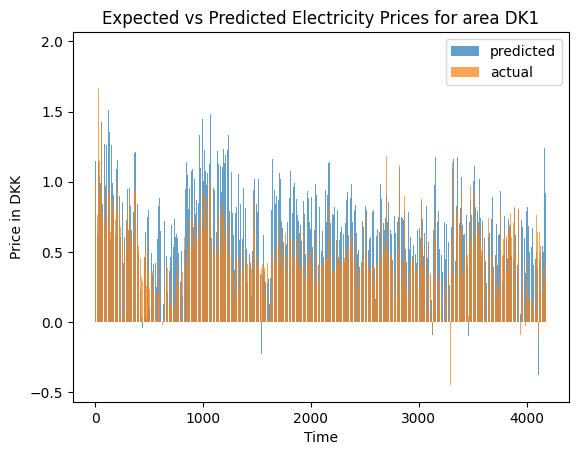

In [25]:
# Importing the matplotlib library for plotting the predictions against the expected values
import matplotlib.pyplot as plt

# Plot the predictions against the expected values
plt.title('Expected vs Predicted Electricity Prices for area DK1')

# Plot the predicted values
plt.bar(x=np.arange(len(y_pred_win)), height=y_pred_win, label='predicted', alpha=0.7)

# Plot the expected values
plt.bar(x=np.arange(len(y_pred_win)), height=y_test_data_win, label='actual', alpha=0.7)

# Add labels to the x-axis and y-axis
plt.xlabel('Time')
plt.ylabel('Price in DKK')

# Add a legend and display the plot
plt.legend()
plt.show() 

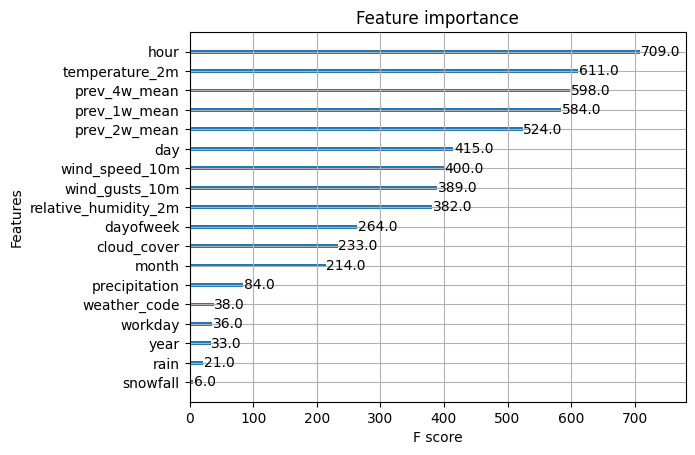

In [26]:
# Import the plot_importance function from XGBoost
from xgboost import plot_importance
# Plot feature importances using the plot_importance function from XGBoost
plot_importance(
    xgb_model_win, 
    max_num_features=25,  # Display the top 25 most important features
)
plt.show()

## <span style='color:#ff5f27'> ⚖️ Model Validation

After fitting the XGBoost Regressor, we evaluate the performance using the following validation metrics.

**Mean Squared Error (MSE):**
- Measures the average squared difference between the actual and predicted values in a regression problem. 
- It squares the differences between predicted and actual values to penalize larger errors more heavily.
- Lower MSE values indicate better model performance.

**R-squared (R²):**
- Measures the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (features) in a regression model.
- R-squared values range from 0 to 1, where 0 indicates that the model does not explain any variability in the target variable, and 1 indicates that the model explains all the variability.
- R-squared is a useful metric for assessing how well the regression model fits the observed data. However, it does not provide information about the goodness of fit on new, unseen data.

**Mean Absolute Error (MAE):**
- Measures the average absolute difference between the actual and predicted values.
- MAE is less sensitive to outliers compared to MSE because it does not square the errors.
- Like MSE and RMSE, lower MAE values indicate better model performance.

MSE focus on the magnitude of errors, while R-squared provides insight into the proportion of variance explained by the model. MAE provides a measure of average error without considering the direction of errors.

In this case, the `MSE` is 0.0546, which suggests that on average, the squared difference between the actual and predicted values is relatively low. An `R^2` value of 0.933 indicates that approximately 93.33% of the variance in the dependent variable is predictable from the feature variables in the model. This is a high value, suggesting that the model explains a significant portion of the variability in the data. A `MAE` of 0.1604 suggests that, on average, the model's predictions are off by approximately 0.1604 units from the actual values. Similar to MSE, a lower MAE indicates better accuracy of the model.

In summary, based on these metrics, the model seems to perform quite well. It has relatively low error (both in terms of MSE and MAE), and a high percentage of the variance in the dependent variable is explained by the feature variables, as indicated by the high R-squared value.

As shown in the above feature importance plot features like `temperature`, `day`, `hour` and `month` are most important for predicting the dependent variable. 

## <span style='color:#2656a3'>🗄 Model Registry</span>

The Model Registry in Hopsworks enable us to store the trained model. The model registry centralizes model management, enabling models to be securely accessed and governed. We can also save model metrics with the model, enabling the user to understand performance of the model on test (or unseen) data.

In [27]:
# Importing the libraries for saving the model
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib

In [28]:
# Retrieving the Model Registry from Hopsworks
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


### <span style="color:#ff5f27;">⚙️ Model Schema</span>
A model schema defines the structure and format of the input and output data that a machine learning model expects and produces, respectively. It serves as a **blueprint** for understanding how to interact with the model in terms of input features and output predictions. In the context of the Hopsworks platform, a model schema is typically defined using the Schema class, which specifies the features expected in the input data and the target variable in the output data. This schema helps ensure consistency and compatibility between the model and the data it operates on.

In [29]:
# Imoprt the os library to interact with the operating system
import os

In [30]:
# Specify the schema of the model's input and output using the features (X_train) and dependent variable (y_train)
# input_schema_lag = Schema(X_train_data_lag)
# output_schema_lag = Schema(y_train_data_lag)

# # Create a model schema using the input and output schemas
# model_schema_lag = ModelSchema(input_schema_lag, output_schema_lag)

In [31]:
# Specify the schema of the model's input and output using the features (X_train) and dependent variable (y_train)
input_schema_win = Schema(X_train_data_win)
output_schema_win = Schema(y_train_data_win)

# Create a model schema using the input and output schemas
model_schema_win = ModelSchema(input_schema_win, output_schema_win)

In [32]:
# Define the directory path (folder path) where the trained model will be exported
model_dir = "model"

# Check if the directory already exists, if not create it
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

In [33]:
# Save the XGBoost Regressor model as joblib file in the model directory
# joblib.dump(xgb_model_win, model_dir + "/dk_electricity_model_lag.pkl")
joblib.dump(xgb_model_win, model_dir + "/dk_electricity_model_win.pkl")

['model/dk_electricity_model_win.pkl']

In [34]:
# # Create an entry in the model registry with the specified details 
# xgb_model_lag = mr.python.create_model(
#     name="electricity_price_prediction_model_lag", # Name of the model
#     metrics={ # Evaluation metrics for the model
#         "MSE": mse_lag,
#         "R squared": r2_lag,
#         "MAE": mae_lag,
#     },
#     model_schema=model_schema_lag, # Schema defining the input and output data structure of the model
#     input_example=X_train_data_win.sample(), # Example input data for the model
#     description="DK1 Electricity Price Predictor Lagged Window" # Description of the model
# )

In [35]:
# Create an entry in the model registry with the specified details 
xgb_model_win = mr.python.create_model(
    name="electricity_price_prediction_model_win", # Name of the model
    metrics={ # Evaluation metrics for the model
        "MSE": mse_win,
        "R squared": r2_win,
        "MAE": mae_win,
    },
    model_schema=model_schema_win, # Schema defining the input and output data structure of the model
    input_example=X_train_data_win.sample(), # Example input data for the model
    description="DK1 Electricity Price Predictor Rolling/Sliding Window" # Description of the model
)

In [36]:
# Upload the model to Hopsworks
# xgb_model_lag.save(model_dir)
xgb_model_win.save(model_dir)

Uploading: 100.000%|██████████| 436134/436134 elapsed<00:02 remaining<00:00  3.51it/s]
Uploading: 100.000%|██████████| 450707/450707 elapsed<00:01 remaining<00:00  3.51it/s]
Uploading: 100.000%|██████████| 429108/429108 elapsed<00:02 remaining<00:00  3.51it/s]
Uploading: 100.000%|██████████| 434893/434893 elapsed<00:01 remaining<00:00  3.51it/s]
Uploading input_example and model_schema:  33%|███▎      | 2/6 [00:08<00:20,  5.18s/it]DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
Uploading: 100.000%|██████████| 142/142 elapsed<00:01 remaining<00:00
Uploading: 100.000%|██████████| 1496/1496 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/550040/models/electricity_price_prediction_model_win/1


Model(name: 'electricity_price_prediction_model_win', version: 1)

## <span style="color:#2656a3;">⏭️ **Next:** Part 04: Batch Inference </span>

Next notebook we will use the registered model to make predictions based on the batch data.